In [1]:
import numpy as np
import pandas as pd
from pybaseball import statcast
df = statcast(start_dt="2022-04-01", end_dt="2022-04-30")
#22年4月のすべての投球を抽出

This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████████████████████████████████████| 30/30 [00:38<00:00,  1.27s/it]


In [2]:
#ワーニングを削除
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
#カラムを省略なく表示
pd.options.display.max_columns = None

In [4]:
#すべてのデータがnanのカラムを削除　92→84
df1 = df.dropna(axis=1, how="all")

In [5]:
#既存の特徴量を削除
df2=df1.drop(columns=["delta_run_exp","delta_home_win_exp","woba_value","estimated_woba_using_speedangle","woba_denom","babip_value","iso_value","estimated_ba_using_speedangle"])

In [6]:
#launch_speed_angleの詳細(のちにlaunch_speed_angleよりも良い指標がないか確認したい)
df_launch = df2[["launch_speed_angle","launch_speed","launch_angle"]]
df_launch[df_launch["launch_speed_angle"]>=3]

,launch_speed_angle,launch_speed,launch_angle
3804,3,95.7,47
3385,3,91.7,36
3936,4,101.8,8
2350,4,98.7,18
2431,4,104.2,1
...,...,...,...
1266,4,100.7,7
1051,5,107.0,14
1168,5,100.5,18
1437,4,85.8,10


In [7]:
#意味合いが重複するカラム/結果を表すカラム/無意味なカラムを削除
df3=df2.drop(columns=["pitch_type","release_speed","events","description","zone","des",
                      "hit_location","bb_type","game_year","hc_x","hc_y","sz_top","sz_bot",
                     "hit_distance_sc","launch_speed","launch_angle","release_extension","post_fld_score",
                     "post_bat_score","post_home_score","post_away_score","fld_score","bat_score"])
df3.shape

(106291, 53)

In [8]:
#人物データを削除(各選手の過去成績によるバイアス削除はまたの機会に...)
df4=df3.drop(columns=["player_name","batter","pitcher","game_pk",
                      "pitcher.1","fielder_2.1","fielder_2","fielder_3","fielder_4","fielder_5",
                      "fielder_6","fielder_7","fielder_8","fielder_9",])
df4.shape

(106291, 39)

In [9]:
#effective_speed(球速)が存在しないレコードを削除
df5= df4.dropna(subset=["effective_speed"])

In [10]:
#ランナーのデータを0,1のデータにする, launch_speed_angleのnanを0にする
df5[["on_3b","on_2b","on_1b"]]=df5[["on_3b","on_2b","on_1b"]].notnull().astype(int)
df5[["on_3b","on_2b","on_1b"]]=df5[["on_3b","on_2b","on_1b"]].fillna(0)
df5["launch_speed_angle"]=df5["launch_speed_angle"].fillna(0)

In [11]:
#ボール球は打者側の打つモチベーションがないため除外
df6= df5[df5["type"]!="B"]

In [12]:
#守備位置の欠損値をstandardで埋める
df6[["of_fielding_alignment","if_fielding_alignment"]]=df6[["of_fielding_alignment","if_fielding_alignment"]].fillna("Standard")

In [13]:
#回転数がわからないレコードを確認
df_nan = df6[df6["spin_axis"].isna()]
df_nan
#傾向がないためすべて削除→欠損値なし
df7= df6.dropna(subset=["spin_axis"])

In [14]:
#天気の取得に必要なgame_date,home_team,away_teamを削除
#既にlsaによって包含できるtypeも削除
df8= df7.drop(columns=["game_date","home_team","away_team","type"])

In [15]:
df8.columns

Index(['release_pos_x', 'release_pos_z', 'game_type', 'stand', 'p_throws',
       'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b',
       'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate',
       'release_pos_y', 'launch_speed_angle', 'at_bat_number', 'pitch_number',
       'pitch_name', 'home_score', 'away_score', 'if_fielding_alignment',
       'of_fielding_alignment', 'spin_axis'],
      dtype='object')

In [16]:
#見やすく並び替え
df9= df8[[ 'launch_speed_angle','effective_speed','release_pos_x', 'release_pos_z',  'release_pos_y','game_type', 'stand', 'p_throws',
       'balls', 'strikes', 'outs_when_up', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b',
       'on_2b', 'on_1b', 'inning', 'inning_topbot', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az',  'release_spin_rate',
       'at_bat_number', 'pitch_number',
       'pitch_name', 'home_score', 'away_score', 'if_fielding_alignment',
       'of_fielding_alignment', 'spin_axis']]

In [17]:
#球速0のカラムを消す(556)
df9["effective_speed"].value_counts()[0]
df10=df9[df9["effective_speed"]!=0]

In [18]:
import seaborn as sns

In [19]:
#文字データの数値化_one hotエンコーディング
df11=pd.get_dummies(df10,drop_first=True)

In [20]:
df11.launch_speed_angle.value_counts()
#LSAをみのがし(0)凡退(1)ヒット・ホームラン性の打球に分類する
df11.loc[df11["launch_speed_angle"].isin([1,2,3]) , "launch_speed_angle"] =1
df11.loc[df11["launch_speed_angle"].isin([4,5,6]) , "launch_speed_angle"] =2
df11.launch_speed_angle.value_counts()
#この3つの値を分類する

0    46821
1    10507
2     6507
Name: launch_speed_angle, dtype: Int64

In [21]:
#ストライクゾーンの中心からの距離というカラムを追加する
df11["plate_ctr"] = np.sqrt((df11["plate_x"])**2 + (df11["plate_z"] -2.5)**2) 
df11

,launch_speed_angle,effective_speed,release_pos_x,release_pos_z,release_pos_y,balls,strikes,outs_when_up,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,inning,vx0,vy0,vz0,ax,ay,az,release_spin_rate,at_bat_number,pitch_number,home_score,away_score,spin_axis,game_type_S,stand_R,p_throws_R,inning_topbot_Top,pitch_name_Changeup,pitch_name_Curveball,pitch_name_Cutter,pitch_name_Eephus,pitch_name_Knuckle Curve,pitch_name_Other,pitch_name_Sinker,pitch_name_Slider,pitch_name_Slow Curve,pitch_name_Split-Finger,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,of_fielding_alignment_Extreme outfield shift,of_fielding_alignment_Standard,of_fielding_alignment_Strategic,plate_ctr
3698,1,94.3,-1.62,5.94,54.06,2,1,0,-0.66,1.36,-0.72,3.43,0,1,1,10,3.822453,-137.072765,-3.849161,-9.234918,31.152066,-14.360307,2085,75,4,1,1,210,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.176138
3999,0,94.9,-1.6,5.99,53.99,1,0,0,-0.79,1.32,-0.31,1.86,0,1,1,10,5.145245,-137.942779,-8.071345,-11.237054,32.47774,-13.701941,2139,75,2,1,1,211,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.711126
2377,1,84.7,-2.14,6.17,54.45,0,0,2,0.37,-0.97,0.16,2.49,1,0,1,10,4.636656,-123.944638,-0.386972,2.870882,25.317741,-42.252764,2331,73,1,1,1,42,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0.160312
2767,1,90.4,-2.02,6.16,54.17,0,0,1,-1.3,0.29,-0.56,2.21,0,1,0,10,6.43306,-131.784622,-4.519893,-16.556546,29.600366,-28.007268,1613,71,1,1,1,250,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.630635
2781,0,87.9,-2.09,6.08,54.29,2,2,0,0.13,0.43,-1.18,2.94,0,1,0,10,1.924056,-127.54814,-2.40055,1.134828,23.258435,-27.227267,2256,70,5,1,1,80,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1.259365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,0,89.9,1.65,5.18,54.45,0,0,1,0.99,0.65,-0.01,2.0,0,0,0,1,-6.189293,-130.948473,-3.332891,12.638022,25.423891,-24.151438,2302,2,1,0,0,131,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0.5001
2112,1,89.0,1.82,5.11,54.51,1,2,0,1.43,0.52,1.15,2.96,0,0,0,1,-4.665504,-130.329751,-0.407013,17.273234,28.188677,-26.360502,2235,1,5,0,0,123,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1.238588
2246,0,83.2,1.6,5.29,54.44,1,2,0,1.1,0.81,0.95,2.13,0,0,0,1,-3.649671,-121.479297,-2.421355,11.638112,23.413516,-23.926343,1436,1,4,0,0,120,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.01951
2634,0,89.4,1.67,5.21,54.41,0,1,0,0.6,1.37,-0.74,3.08,0,0,0,1,-7.213822,-130.731386,-2.191276,8.449255,28.552852,-16.179199,2454,1,2,0,0,125,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.940213


In [104]:
df_ee = df11[df11["pitch_name_Eephus"]==1]
df_ee

,launch_speed_angle,effective_speed,release_pos_x,release_pos_z,release_pos_y,balls,strikes,outs_when_up,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,inning,vx0,vy0,vz0,ax,ay,az,release_spin_rate,at_bat_number,pitch_number,home_score,away_score,spin_axis,game_type_S,stand_R,p_throws_R,inning_topbot_Top,pitch_name_Changeup,pitch_name_Curveball,pitch_name_Cutter,pitch_name_Eephus,pitch_name_Knuckle Curve,pitch_name_Other,pitch_name_Sinker,pitch_name_Slider,pitch_name_Slow Curve,pitch_name_Split-Finger,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,of_fielding_alignment_Extreme outfield shift,of_fielding_alignment_Standard,of_fielding_alignment_Strategic,plate_ctr
1976,0,49.3,-0.98,7.03,56.22,2,1,2,0.96,-1.32,0.52,1.22,0,0,0,8,0.924721,-74.678987,3.75027,3.443837,10.185812,-37.814632,1881,76,4,13,2,29,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1.381593
3042,2,52.9,-1.33,6.75,56.21,2,2,1,0.96,-1.45,0.83,0.68,0,0,0,8,1.963514,-80.321091,2.368406,3.810391,12.177114,-38.965036,1991,73,7,11,2,35,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.000325
4004,2,59.9,-1.02,6.68,55.77,1,2,0,0.89,-1.29,-0.54,3.09,0,0,0,8,-0.45152,-90.005204,4.332236,4.847209,14.37273,-40.038306,2017,72,4,11,2,33,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0.799812


In [22]:
#ロジスティック回帰による分類 

#hold-out法(時間短縮のため)
from sklearn.model_selection import train_test_split
X = df11.loc[: , df11.columns!="launch_speed_angle"]
y = df11["launch_speed_angle"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
y_train = y_train.astype(int)

#ロジスティック回帰
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="none")
model.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [23]:
#ロジスティック回帰によるLSAの分類予測確率
print(model.classes_)
print(model.predict_proba(X_test))

[0 1 2]
[[0.75193365 0.15044403 0.09762232]
 [0.72235085 0.18771768 0.08993148]
 [0.75657771 0.13228566 0.11113663]
 ...
 [0.73640262 0.16919396 0.09440342]
 [0.75546118 0.15277979 0.09175903]
 [0.79813197 0.10457781 0.09729022]]


In [24]:
#すべて0と予想してしまっている
df_log=pd.DataFrame(model.predict(X_test))
df_log.value_counts()

0    19151
dtype: int64

In [25]:
pd.DataFrame(model.feature_names_in_)

,0
0,effective_speed
1,release_pos_x
2,release_pos_z
3,release_pos_y
4,balls
5,strikes
6,outs_when_up
7,pfx_x
8,pfx_z
9,plate_x


In [177]:
model.coef_[2]

array([-3.05208220e-03,  3.93505014e-05, -3.99555815e-04, -5.88455351e-03,
        2.63509126e-03,  2.95588095e-03, -1.30329450e-04, -2.44818713e-04,
        5.62903246e-04, -1.82117450e-04,  5.49676993e-04,  8.23243123e-05,
       -8.23952028e-05,  1.91265646e-04,  5.45757441e-06,  3.12879636e-04,
        4.35814400e-03, -8.74712602e-04, -3.33989592e-03, -4.56127072e-05,
        1.07191732e-02,  2.26740969e-04, -1.35401066e-04,  6.15257127e-03,
        9.52652660e-06,  2.22751688e-04,  2.34463290e-04, -3.89347393e-05,
        2.49015235e-05,  3.19947589e-05, -1.28213202e-04, -3.40301940e-04,
       -1.76040873e-04,  7.11708623e-05,  3.24736032e-06,  2.38804283e-07,
        1.25028624e-05,  2.05197871e-04, -2.99626010e-04,  2.53727288e-06,
       -1.12791153e-04,  6.97710079e-05,  5.93756830e-05,  0.00000000e+00,
       -1.16529358e-04, -9.56690285e-06, -2.87945795e-03])

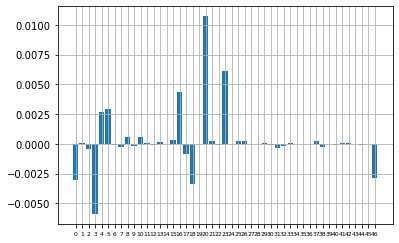

In [182]:
#強打される時の各変数の影響度
import matplotlib.pyplot as plt
plt.bar(range(len(model.coef_[2])),model.coef_[2])
plt.xticks(range(len(model.coef_[2])))
plt.gca().tick_params(axis='x', labelsize=6)
plt.grid()
plt.show()

In [27]:
#20 高さ方向の加速度が大きい(球が垂れる)と打たれやすい
#23 試合の後半ほど打たれやすい
#3 リリースポイントが前だと打たれにくい(リリースポイント以外の条件が同じ場合)
#26　回転軸が大きいと打たれやすい(バックスピンは180°)→変化球との関係を示しているっぽい

In [28]:
y_test = np.array(y_test)
y_test = y_test.astype(int)
y_test

array([1, 0, 0, ..., 0, 0, 0])

In [30]:
#accurcyとマルチloglossによって精度確認
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

#logloss
from sklearn.metrics import log_loss
y_pred_proba = model.predict_proba(X_test)
logloss = log_loss(y_test,y_pred_proba)
print("logloss         {:.4f}".format(logloss))

#正則化なしの方が精度が高い

0.735261866221085
logloss         0.7510


In [31]:
#決定木による学習によるモデル作成
from sklearn import tree
model_dt = tree.DecisionTreeClassifier(max_depth=4)
model_dt.fit(X_train, y_train)

#精度確認
print(accuracy_score(y_test, model_dt.predict(X_test)))
print(log_loss(y_test, model_dt.predict_proba(X_test)))

0.735261866221085
0.728518723586577


In [32]:
dt = pd.DataFrame(model_dt.predict(X_test))
dt.value_counts()

0    19151
dtype: int64

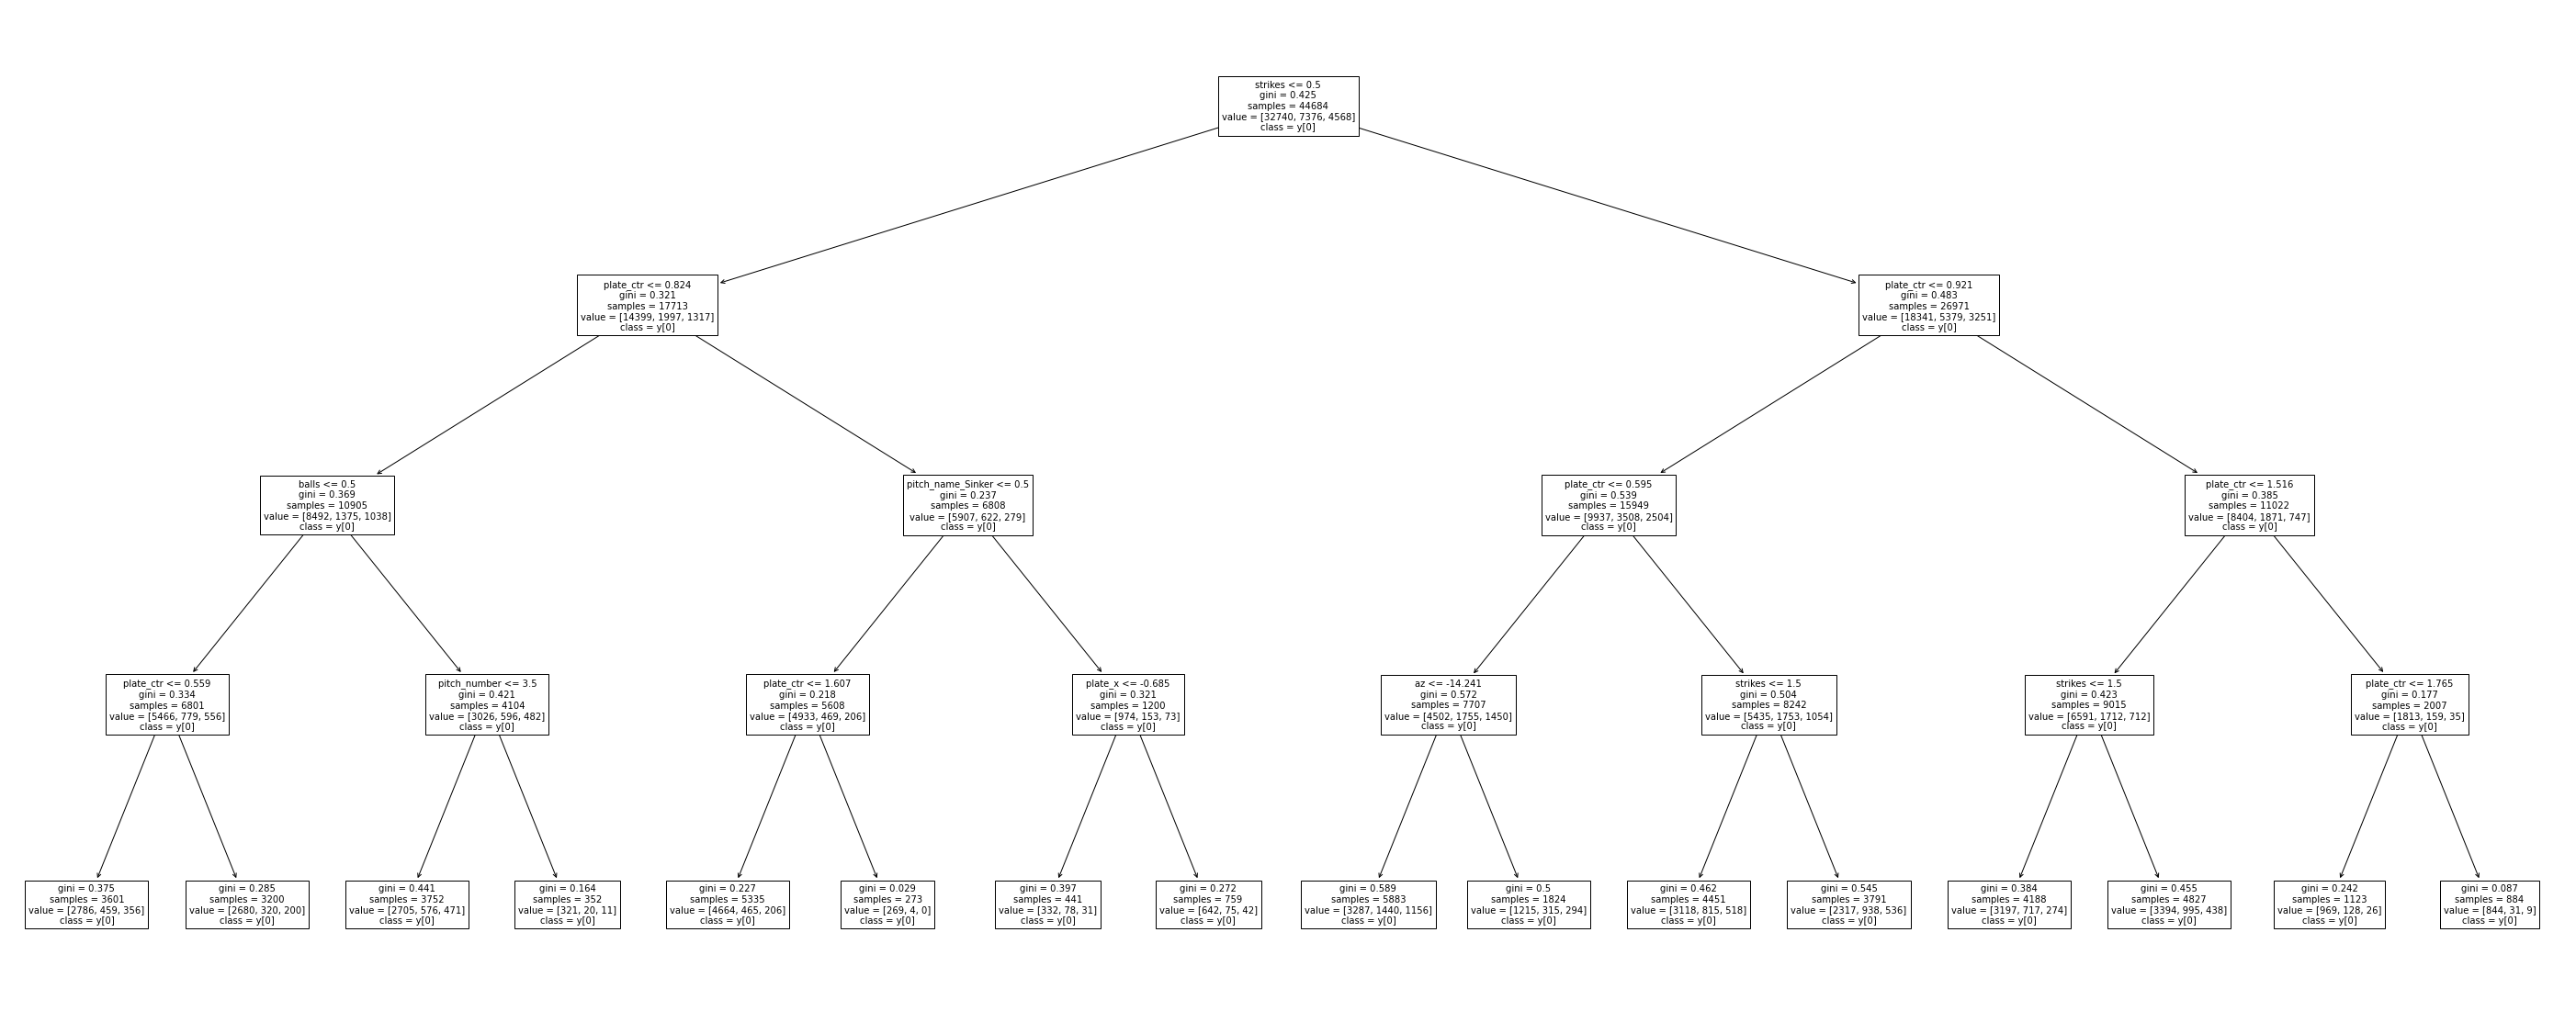

In [35]:
#決定木モデルの可視化(条件を満たす場合は左のノードへ進む)
plt.figure(figsize=(50,20))
_=tree.plot_tree(model_dt, fontsize=10, feature_names=X.columns, class_names=True)

In [77]:
#ニューラルネットワークによる分類
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

#標準化(dataframe→ndarray)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s = pd.get_dummies(y_train, drop_first=False)

#ニューラルネットワークの構築
model_n = Sequential()
model_n.add(Dense(64, input_dim=X_train_s.shape[1], activation="relu"))
model_n.add(Dense(32, activation="relu"))
model_n.add(Dense(3, activation="softmax"))

#モデルをコンパイルする
model_n.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#学習
model_n.fit(X_train_s, y_train_s, epochs=16, batch_size=32)

Epoch 1/16
1397/1397 [==============================] - 2s 896us/step - loss: 0.7421 - accuracy: 0.7277
Epoch 2/16
1397/1397 [==============================] - 1s 878us/step - loss: 0.7208 - accuracy: 0.7327
Epoch 3/16
1397/1397 [==============================] - 1s 891us/step - loss: 0.7149 - accuracy: 0.7326
Epoch 4/16
1397/1397 [==============================] - 1s 889us/step - loss: 0.7110 - accuracy: 0.7328
Epoch 5/16
1397/1397 [==============================] - 1s 928us/step - loss: 0.7078 - accuracy: 0.7329
Epoch 6/16
1397/1397 [==============================] - 1s 875us/step - loss: 0.7046 - accuracy: 0.7329
Epoch 7/16
1397/1397 [==============================] - 1s 898us/step - loss: 0.7013 - accuracy: 0.7332
Epoch 8/16
1397/1397 [==============================] - 1s 871us/step - loss: 0.6987 - accuracy: 0.7336
Epoch 9/16
1397/1397 [==============================] - 1s 866us/step - loss: 0.6951 - accuracy: 0.7338
Epoch 10/16
1397/1397 [==============================] - 1s 895u

In [82]:
#NNモデルの評価
model_n.evaluate(X_test_s, pd.get_dummies(y_test))

599/599 [==============================] - 1s 767us/step - loss: 0.7466 - accuracy: 0.7248


[0.7465788722038269, 0.7248185276985168]

In [164]:
##NNモデルの結果
model_n.predict(X_test_s)
X_test_s.shape

599/599 [==============================] - 0s 693us/step


(19151, 47)

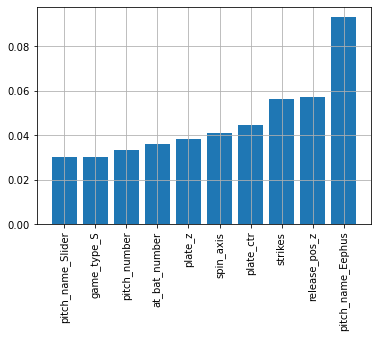

In [168]:
 #NNモデルの重み
weights = model_n.layers[0].get_weights()[0]
#可視化
#plt.bar(np.arange(weights.shape[0]),abs(np.mean(weights,axis=1)))

#重みが大きい順に10個並べる
important_features = np.argsort(abs(np.mean(weights, axis=1)))[-10:]
#この10個のみを抽出してグラフ化
plt.bar(np.arange(10), abs(np.mean(weights, axis=1)[important_features]))
#ラベルに変数の名前を追加
feature_names = model.feature_names_in_
feature_names = [feature_names[i] for i in important_features]
plt.xticks(np.arange(10),feature_names, rotation=90)

plt.grid()
plt.show()

In [186]:
#lingam因果推論(左ほど原因,右ほど結果)
import lingam

model_lin = lingam.DirectLiNGAM()
model_lin.fit(df11)
print(model_lin.causal_order_)

[44, 40, 37, 35, 41, 36, 46, 45, 28, 43, 12, 34, 33, 32, 13, 14, 31, 0, 7, 30, 38, 29, 42, 39, 6, 5, 24, 47, 11, 19, 10, 22, 26, 25, 4, 3, 15, 17, 20, 1, 21, 9, 18, 23, 16, 2, 8, 27]


In [189]:
from lingam.utils import make_dot
make_dot(model_lin.adjacency_matrix_)


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [90]:
weights.shape[0]

47

<AxesSubplot:xlabel='release_pos_y'>

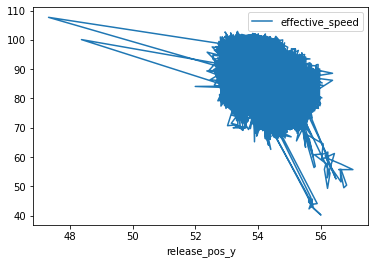

In [45]:
df11.plot(x="release_pos_y", y= "effective_speed")


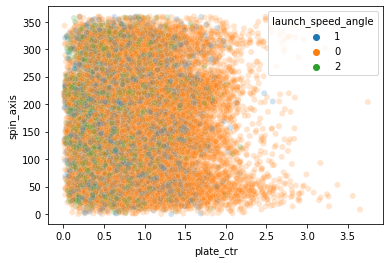

In [111]:
#打たれやすいゾーンの可視化 2次元
dataa=df11

dataa["launch_speed_angle"]=dataa["launch_speed_angle"].astype(str)
sns.scatterplot(x="plate_ctr",y = "spin_axis",hue="launch_speed_angle",data=dataa, alpha=0.2)
dataa["launch_speed_angle"]=dataa["launch_speed_angle"].astype(int)